In [1]:
import numpy as np
from _utility import *

c_p_base = 6000  # P-wave velocity (m/s)
c_s_base = 3500  # S-wave velocity (m/s)
rho_base = 2700  # Base density (kg/m³)
S_base = create_compliance_matrix_from_velocities(c_p_base, c_s_base, rho_base)

Nx, Ny, Nz = 16, 16, 16
dx = dy = dz = 0.05

ADD_FRACTURES = True

# Fracture properties (water-filled fractures)
rho_fracture = 270  # 1000 is Water density (kg/m³)
K_water = 2.2e9  # Water bulk modulus (Pa)
mu_fracture = 1e-6  # Very small shear modulus for numerical stability
lambda_fracture = K_water  # Bulk modulus for λ

# Compute base material Lamé parameters
mu_base = rho_base * c_s_base ** 2
lambda_base = rho_base * c_p_base ** 2 - 2 * mu_base

print(f"\nFracture properties (water-filled):")
print(f"  λ_fracture = {lambda_fracture:.2e} Pa")
print(f"  μ_fracture = {mu_fracture:.2e} Pa")
print(f"  ρ_fracture = {rho_fracture:.1f} kg/m³")
print(f"  Expected c_p = {np.sqrt((lambda_fracture + 2 * mu_fracture) / rho_fracture):.1f} m/s")

# ============================================================================
# CREATE DENSITY MODEL WITH FRACTURES
# ============================================================================
rho_model = np.full((Nz, Ny, Nx), rho_base)
fracture_mask = np.zeros((Nz, Ny, Nx), dtype=bool)

if ADD_FRACTURES:
    # Two perpendicular fracture planes: horizontal (z) and vertical (x)
    fracture1_z = Nz // 2  # Horizontal plane (constant z)
    fracture2_x = Nx // 2  # Vertical plane (constant x)
    fracture_thickness = 0

    print(f"\nAdding 2 perpendicular fracture planes:")
    print(f"  Fracture 1: Horizontal plane at z-index {fracture1_z}")
    print(f"  Fracture 2: Vertical plane at x-index {fracture2_x}")

    fracture_cells = 0
    for i in range(Nz):
        for j in range(Ny):
            for k in range(Nx):
                is_fracture = (abs(i - fracture1_z) <= fracture_thickness or
                               abs(k - fracture2_x) <= fracture_thickness)
                if is_fracture:
                    fracture_mask[i, j, k] = True
                    fracture_cells += 1
                    rho_model[i, j, k] = rho_fracture

    print(
        f"  Total fracture cells: {fracture_cells} out of {Nx * Ny * Nz} ({100 * fracture_cells / (Nx * Ny * Nz):.1f}%)")

# Clip density to reasonable bounds
rho_model = np.clip(rho_model, 1.0, 3000)

print(f"\nDensity Model Statistics:")
print(f"  Min: {np.min(rho_model):.1f} kg/m³, Max: {np.max(rho_model):.1f} kg/m³")
print(f"  Mean: {np.mean(rho_model):.1f} kg/m³, Std: {np.std(rho_model):.1f} kg/m³")

# ============================================================================
# CREATE SPATIALLY VARYING COMPLIANCE MATRIX
# ============================================================================
need_varying_S = ADD_FRACTURES

if need_varying_S:
    S_model = np.zeros((6, 6, Nz, Ny, Nx))

    for i in range(Nz):
        for j in range(Ny):
            for k in range(Nx):
                if fracture_mask[i, j, k]:
                    S_model[:, :, i, j, k] = create_compliance_matrix_isotropic(
                        lambda_fracture, mu_fracture
                    )
                else:
                    S_model[:, :, i, j, k] = S_base

    S = S_model
else:
    S = S_base

# ============================================================================
# COMPUTE HAMILTONIAN
# ============================================================================

# Grid sizes for staggered grids
N_main = Nx * Ny * Nz
N_vx = (Nx - 1) * Ny * Nz
N_vy = Nx * (Ny - 1) * Nz
N_vz = Nx * Ny * (Nz - 1)
N_sxy = (Nx - 1) * (Ny - 1) * Nz
N_sxz = (Nx - 1) * Ny * (Nz - 1)
N_syz = Nx * (Ny - 1) * (Nz - 1)
N_vel = N_vx + N_vy + N_vz
N_stress = 3 * N_main + N_sxy + N_sxz + N_syz
N_total = N_vel + N_stress

H, A, B, B_sqrt, B_inv, B_inv_sqrt = FD_solver_3D_elastic(
    Nx, Ny, Nz, dx, dy, dz, rho_model, S
)

# Check A is anti-Hermitian (A† = -A); then H = i B^{-1/2} A B^{-1/2} is Hermitian
A_sum = A + A.T
if hasattr(A_sum, 'data') and len(A_sum.data) > 0:
    A_anti_hermitian_error = np.max(np.abs(A_sum.data))
else:
    A_sum_dense = A_sum.toarray() if hasattr(A_sum, 'toarray') else A_sum
    A_anti_hermitian_error = np.max(np.abs(A_sum_dense)) if A_sum_dense.size > 0 else 0.0

if A_anti_hermitian_error < 1e-10:
    print(f"Matrix A is anti-Hermitian (A† = -A)")
else:
    print(f"WARNING: A may not be anti-Hermitian (max |A + A^T|: {A_anti_hermitian_error:.2e})")

# Verify H is Hermitian (H† = H) for unitary evolution and energy conservation
H_diff = H - H.conj().T
if hasattr(H_diff, 'data') and len(H_diff.data) > 0:
    H_hermitian_error = np.max(np.abs(H_diff.data))
else:
    H_diff_dense = H_diff.toarray() if hasattr(H_diff, 'toarray') else H_diff
    H_hermitian_error = np.max(np.abs(H_diff_dense)) if H_diff_dense.size > 0 else 0.0

if H_hermitian_error < 1e-10:
    print(f"Hamiltonian H is Hermitian (H† = H) - energy will be conserved")
else:
    print(f"WARNING: H may not be Hermitian (max |H - H†|: {H_hermitian_error:.2e})")

# ============================================================================
# TIME EVOLUTION SETUP
# ============================================================================
print(f"\n" + "=" * 60)
print("WAVE EVOLUTION")
print("=" * 60)

phi_0 = np.zeros(N_total, dtype=complex)

x = np.arange(Nx) * dx - (Nx - 1) * dx / 2
y = np.arange(Ny) * dy - (Ny - 1) * dy / 2
z = np.arange(Nz) * dz - (Nz - 1) * dz / 2
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
sigma = 2.5 * dx
amplitude = 0.005
gaussian = amplitude * np.exp(-(X ** 2 + Y ** 2 + Z ** 2) / (2 * sigma ** 2))
# gaussian = amplitude * np.exp(-(X ** 2 + Y ** 2 + (Z + something) ** 2) / (2 * sigma ** 2))

# Add compressional stress (equal diagonal components).
# State vector uses (z, y, x) order (x fastest); meshgrid gives (Nx, Ny, Nz), so transpose then flatten.
g_flat = np.ascontiguousarray(gaussian.transpose(2, 1, 0)).flatten()  # (Nz, Ny, Nx) order
idx = N_vel
phi_0[idx:idx + N_main] = g_flat  # σ_xx
idx += N_main
phi_0[idx:idx + N_main] = g_flat  # σ_yy
idx += N_main
phi_0[idx:idx + N_main] = g_flat  # σ_zz

# CFL condition for time step
if need_varying_S and ADD_FRACTURES:
    c_p_fracture = np.sqrt((lambda_fracture + 2 * mu_fracture) / rho_fracture)
    c_p_min = min(c_p_fracture, c_p_base)
else:
    c_p_min = c_p_base

dt_max = dx / c_p_min
safety_factor = 0.01 if need_varying_S and ADD_FRACTURES else 0.1
dt = safety_factor * dt_max
n_steps = 20
t_final = n_steps * dt

# Initial stress scale (for sanity check)
sigma_0_max = np.max(np.abs(phi_0[N_vel:]))
print(f"Initial stress max |σ|: {sigma_0_max:.4e}")
print(f"Time step: {dt:.2e} s ({n_steps} steps, final time: {t_final:.2e} s)")

# ============================================================================
# TIME EVOLUTION (Energy Basis)
# ============================================================================
from scipy.sparse.linalg import expm_multiply

# Transform to energy basis (required for Hamiltonian evolution)
psi_0 = B_sqrt @ phi_0
initial_norm = np.linalg.norm(psi_0)
psi_current = psi_0.copy() / initial_norm
norm_factor = initial_norm

n_substeps_per_step = 100  # many small steps for accurate exp(-iH dt)
dt_sub = dt / n_substeps_per_step
print(f"Using {n_substeps_per_step} sub-steps per main step (dt_sub = {dt_sub:.2e} s)")

# Evolve in energy basis: psi(t+dt) = exp(-i H dt) psi(t).
# We use many sub-steps (dt_sub = dt / n_substeps_per_step) because H = i B_inv_sqrt A B_inv_sqrt
# can have a very large norm when density/compliance vary (e.g. fractures). The matrix exponential
# exp(-i H tau) is accurate only when tau*||H|| is modest; a single step with dt would be unstable
# or inaccurate. Sub-stepping keeps each exp(-i H dt_sub) well-conditioned.
# Refs: Al-Mohy & Higham (2011) SIAM J. Sci. Comput. "Computing the Action of the Matrix
# Exponential"; Higham (2005) SIAM J. Matrix Anal. Appl. "The Scaling and Squaring Method for the Matrix
# Exponential Revisited".
for k in range(n_steps * n_substeps_per_step):
    psi_current = expm_multiply(-1j * H * dt_sub, psi_current)
    if (k + 1) % n_substeps_per_step != 0:
        continue
    step_num = (k + 1) // n_substeps_per_step
    ratio = np.linalg.norm(psi_current)  # should stay ~1 (Hermitian H => unitary evolution)
    if step_num % 5 == 0 or step_num == 1 or step_num == n_steps:
        print(f"  Step {step_num}/{n_steps}: energy ratio = {ratio:.6f}")
    if ratio > 1e4 or ratio < 1e-4:
        print("  Energy explosion detected - stopping simulation")
        break

# Transform back to physical basis
phi_evolved = B_inv_sqrt @ (norm_factor * psi_current)

# ============================================================================
# RESULTS AND VISUALIZATION
# ============================================================================
print(f"\nEvolution complete!")

# Energy conservation check
initial_energy = initial_norm
final_energy = np.linalg.norm(norm_factor * psi_current)
energy_ratio_final = final_energy / initial_energy if initial_energy > 0 else np.nan

print(f"Energy conservation: {energy_ratio_final:.6f}")
if abs(energy_ratio_final - 1.0) > 0.1:
    print(f"  Energy not conserved! (should be ≈ 1.0)")

# Extract fields for visualization
phi_real = np.real(phi_evolved)

idx = 0
v_x = phi_real[idx:idx + N_vx].reshape(Nz, Ny, Nx - 1)
idx += N_vx
v_y = phi_real[idx:idx + N_vy].reshape(Nz, Ny - 1, Nx)
idx += N_vy
v_z = phi_real[idx:idx + N_vz].reshape(Nz - 1, Ny, Nx)
idx += N_vz

σ_xx = phi_real[idx:idx + N_main].reshape(Nz, Ny, Nx)
idx += N_main
σ_yy = phi_real[idx:idx + N_main].reshape(Nz, Ny, Nx)
idx += N_main
σ_zz = phi_real[idx:idx + N_main].reshape(Nz, Ny, Nx)

# Calculate auto-scaling for visualization (because velocity may be much smaller than stress)
v_max = max(np.max(np.abs(v_x)), np.max(np.abs(v_y)), np.max(np.abs(v_z)))
sigma_max = max(np.max(np.abs(σ_xx)), np.max(np.abs(σ_yy)), np.max(np.abs(σ_zz)))

print(f"\nField statistics:")
print(f"  Velocity: max = {v_max:.4e}")
print(f"  Stress: max = {sigma_max:.4e}")

if v_max > 0 and sigma_max > 0:
    target_ratio = 0.25
    scale_stress_auto = 0.5
    scale_v_auto = max(1.0, (sigma_max / v_max) * target_ratio * scale_stress_auto)
    print(f"  Visualization scales: velocity={scale_v_auto:.1f}, stress={scale_stress_auto:.1f}")
else:
    scale_v_auto = 20.0
    scale_stress_auto = 5.0


Fracture properties (water-filled):
  λ_fracture = 2.20e+09 Pa
  μ_fracture = 1.00e-06 Pa
  ρ_fracture = 270.0 kg/m³
  Expected c_p = 2854.5 m/s

Adding 2 perpendicular fracture planes:
  Fracture 1: Horizontal plane at z-index 8
  Fracture 2: Vertical plane at x-index 8
  Total fracture cells: 496 out of 4096 (12.1%)

Density Model Statistics:
  Min: 270.0 kg/m³, Max: 2700.0 kg/m³
  Mean: 2405.7 kg/m³, Std: 792.8 kg/m³
Matrix A is anti-Hermitian (A† = -A)
Hamiltonian H is Hermitian (H† = H) - energy will be conserved

WAVE EVOLUTION
Initial stress max |σ|: 4.7088e-03
Time step: 1.75e-07 s (20 steps, final time: 3.50e-06 s)
Using 100 sub-steps per main step (dt_sub = 1.75e-09 s)
  Step 1/20: energy ratio = 1.000000
  Step 5/20: energy ratio = 1.000000
  Step 10/20: energy ratio = 1.000000
  Step 15/20: energy ratio = 1.000000
  Step 20/20: energy ratio = 1.000000

Evolution complete!
Energy conservation: 1.000000

Field statistics:
  Velocity: max = 2.8824e-10
  Stress: max = 4.7088e-

In [2]:
def unpack_phi_real(phi, Nx, Ny, Nz):
    """
    Unpacks the 1D physical state vector (phi_real) into a dictionary 
    of 9 properly reshaped 3D numpy arrays corresponding to the 
    staggered grid components of the 3D elastic wave equation.
    """
    # 1. Define staggered grid sizes
    N_main = Nx * Ny * Nz
    N_vx = (Nx - 1) * Ny * Nz
    N_vy = Nx * (Ny - 1) * Nz
    N_vz = Nx * Ny * (Nz - 1)
    N_sxy = (Nx - 1) * (Ny - 1) * Nz
    N_sxz = (Nx - 1) * Ny * (Nz - 1)
    N_syz = Nx * (Ny - 1) * (Nz - 1)
    
    # 2. Extract and reshape fields using a running index
    idx = 0
    
    # -- Velocity Components --
    v_x = phi[idx : idx + N_vx].reshape(Nz, Ny, Nx - 1)
    idx += N_vx
    
    v_y = phi[idx : idx + N_vy].reshape(Nz, Ny - 1, Nx)
    idx += N_vy
    
    v_z = phi[idx : idx + N_vz].reshape(Nz - 1, Ny, Nx)
    idx += N_vz
    
    # -- Normal Stress Components --
    sigma_xx = phi[idx : idx + N_main].reshape(Nz, Ny, Nx)
    idx += N_main
    
    sigma_yy = phi[idx : idx + N_main].reshape(Nz, Ny, Nx)
    idx += N_main
    
    sigma_zz = phi[idx : idx + N_main].reshape(Nz, Ny, Nx)
    idx += N_main
    
    # -- Shear Stress Components --
    sigma_xy = phi[idx : idx + N_sxy].reshape(Nz, Ny - 1, Nx - 1)
    idx += N_sxy
    
    sigma_xz = phi[idx : idx + N_sxz].reshape(Nz - 1, Ny, Nx - 1)
    idx += N_sxz
    
    sigma_yz = phi[idx : idx + N_syz].reshape(Nz - 1, Ny - 1, Nx)
    
    # 3. Return as a dictionary for easy access
    return {
        'v_x': v_x, 'v_y': v_y, 'v_z': v_z,
        'sigma_xx': sigma_xx, 'sigma_yy': sigma_yy, 'sigma_zz': sigma_zz,
        'sigma_xy': sigma_xy, 'sigma_xz': sigma_xz, 'sigma_yz': sigma_yz
    }

In [3]:
# Unpack the array
fields = unpack_phi_real(phi_real, Nx, Ny, Nz)

# Access individual 3D numpy arrays
print(f"v_x shape: {fields['v_x'].shape}")
print(f"v_y shape: {fields['v_y'].shape}")
print(f"v_z shape: {fields['v_z'].shape}")
print(f"sigma_xx shape: {fields['sigma_xx'].shape}")
print(f"sigma_yy shape: {fields['sigma_xx'].shape}")
print(f"sigma_zz shape: {fields['sigma_xx'].shape}")
print(f"sigma_xy shape: {fields['sigma_xx'].shape}")
print(f"sigma_xz shape: {fields['sigma_xx'].shape}")
print(f"sigma_yz shape: {fields['sigma_xx'].shape}")

v_x shape: (16, 16, 15)
v_y shape: (16, 15, 16)
v_z shape: (15, 16, 16)
sigma_xx shape: (16, 16, 16)
sigma_yy shape: (16, 16, 16)
sigma_zz shape: (16, 16, 16)
sigma_xy shape: (16, 16, 16)
sigma_xz shape: (16, 16, 16)
sigma_yz shape: (16, 16, 16)


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_fields_slice(fields, k=4, Nx=8, Ny=8, Nz=8):
    """
    Interpolates staggered grid components to the main grid and plots all 
    9 physical components + velocity magnitude at a specific z-slice (z=k).
    """
    # 1. Interpolate Velocity fields to the main grid
    v_x_main = np.zeros((Nz, Ny, Nx))
    v_x_main[:, :, 0] = fields['v_x'][:, :, 0]
    v_x_main[:, :, -1] = fields['v_x'][:, :, -1]
    v_x_main[:, :, 1:-1] = 0.5 * (fields['v_x'][:, :, :-1] + fields['v_x'][:, :, 1:])
    
    v_y_main = np.zeros((Nz, Ny, Nx))
    v_y_main[:, 0, :] = fields['v_y'][:, 0, :]
    v_y_main[:, -1, :] = fields['v_y'][:, -1, :]
    v_y_main[:, 1:-1, :] = 0.5 * (fields['v_y'][:, :-1, :] + fields['v_y'][:, 1:, :])
    
    v_z_main = np.zeros((Nz, Ny, Nx))
    v_z_main[0, :, :] = fields['v_z'][0, :, :]
    v_z_main[-1, :, :] = fields['v_z'][-1, :, :]
    v_z_main[1:-1, :, :] = 0.5 * (fields['v_z'][:-1, :, :] + fields['v_z'][1:, :, :])
    
    # Calculate Velocity Magnitude
    v_mag_main = np.sqrt(v_x_main**2 + v_y_main**2 + v_z_main**2)

    # 2. Interpolate Shear Stress fields to the main grid
    # Using nearest neighbor interpolation to match the 3D plot logic in _utility.py
    s_xy_main = np.zeros((Nz, Ny, Nx))
    s_xy_main[:, 1:, 1:] = fields['sigma_xy']
    
    s_xz_main = np.zeros((Nz, Ny, Nx))
    s_xz_main[1:, :, 1:] = fields['sigma_xz']
    
    s_yz_main = np.zeros((Nz, Ny, Nx))
    s_yz_main[1:, 1:, :] = fields['sigma_yz']

    # 3. Extract the 2D slices at z = k
    slices = {
        'v_x': v_x_main[k, :, :],
        'v_y': v_y_main[k, :, :],
        'v_z': v_z_main[k, :, :],
        'v_mag': v_mag_main[k, :, :],
        'sigma_xx': fields['sigma_xx'][k, :, :],
        'sigma_yy': fields['sigma_yy'][k, :, :],
        'sigma_zz': fields['sigma_zz'][k, :, :],
        'sigma_xy': s_xy_main[k, :, :],
        'sigma_xz': s_xz_main[k, :, :],
        'sigma_yz': s_yz_main[k, :, :]
    }

    # 4. Plotting
    fig, axes = plt.subplots(2, 5, figsize=(22, 8))
    fig.suptitle(f'Wavefield Components at Z-Slice: k={k}', fontsize=16, fontweight='bold')
    
    # Define layout order and colormaps
    # (Velocity magnitude is strictly positive, so we use 'viridis'. The rest use 'RdBu' for positive/negative swings)
    plot_layout = [
        ('v_x', 'Velocity X', 'RdBu'),
        ('v_y', 'Velocity Y', 'RdBu'),
        ('v_z', 'Velocity Z', 'RdBu'),
        ('v_mag', 'Velocity Magnitude', 'viridis'),
        ('sigma_xx', 'Normal Stress XX', 'RdBu'),
        ('sigma_yy', 'Normal Stress YY', 'RdBu'),
        ('sigma_zz', 'Normal Stress ZZ', 'RdBu'),
        ('sigma_xy', 'Shear Stress XY', 'RdBu'),
        ('sigma_xz', 'Shear Stress XZ', 'RdBu'),
        ('sigma_yz', 'Shear Stress YZ', 'RdBu')
    ]

    # Iterate through subplots and plot
    for ax, (key, title, cmap) in zip(axes.flatten(), plot_layout):
        data = slices[key]
        
        # Center the diverging colormaps around 0 for physically intuitive visualization
        if cmap == 'RdBu':
            vmax = np.max(np.abs(data))
            vmin = -vmax if vmax > 0 else -1e-10
            im = ax.imshow(data, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
        else:
            im = ax.imshow(data, cmap=cmap, origin='lower')
            
        ax.set_title(title)
        ax.set_xlabel('X index')
        ax.set_ylabel('Y index')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

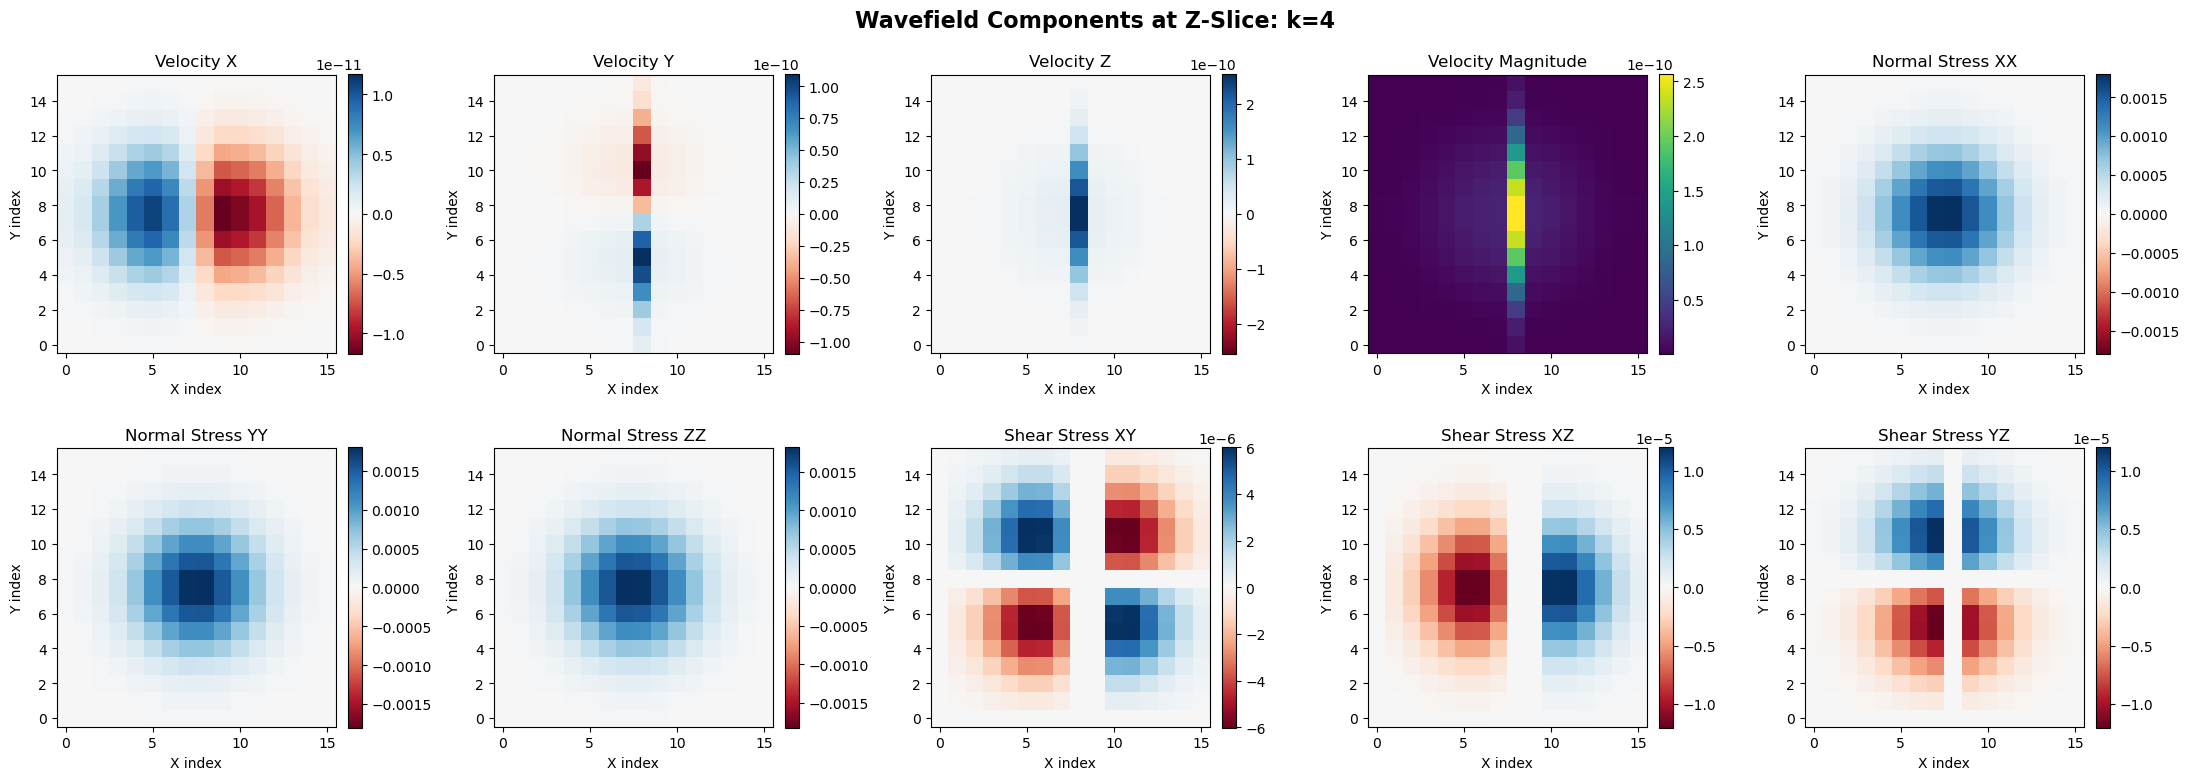

In [5]:
plot_all_fields_slice(fields, k=4, Nx=Nx, Ny=Ny, Nz=Nz)

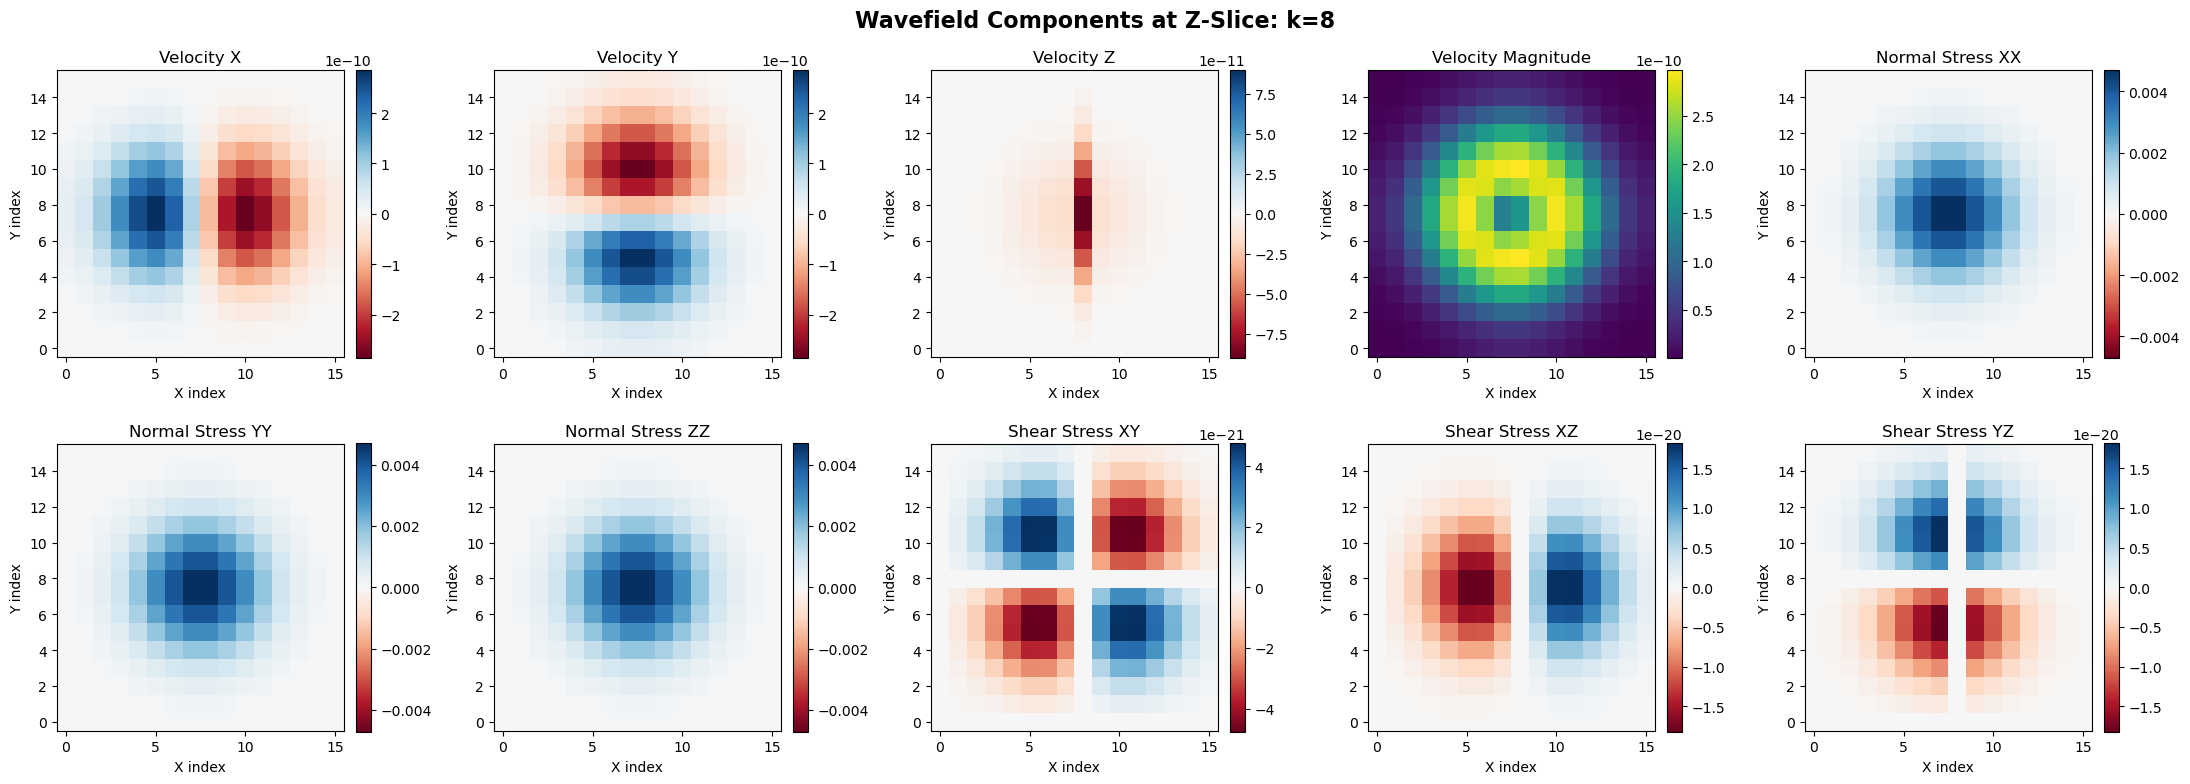

In [6]:
plot_all_fields_slice(fields, k=8, Nx=Nx, Ny=Ny, Nz=Nz)

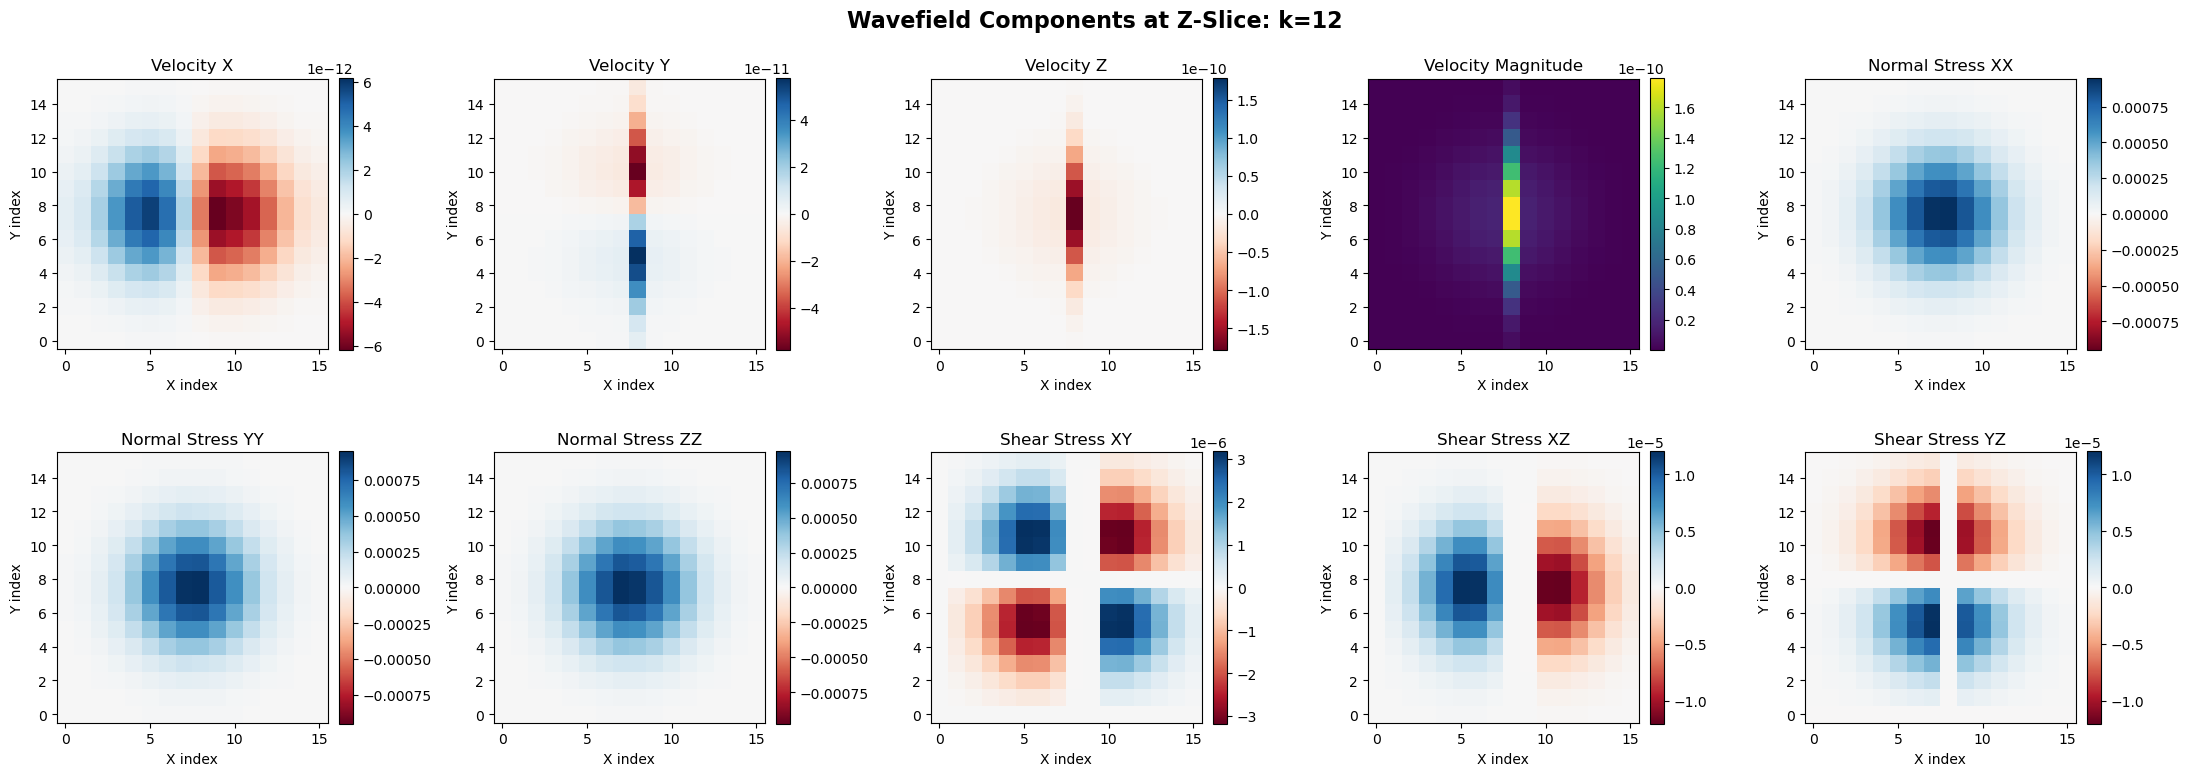

In [7]:
plot_all_fields_slice(fields, k=12, Nx=Nx, Ny=Ny, Nz=Nz)

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def plot_exact_style_slider(fields, Nx=8, Ny=8, Nz=8):
    """
    Produces the exact same visual output as 'plot_all_fields_slice'
    (including colorbars, ticks, and labels) but stacked with a slider.
    """
    # 1. Pre-compute interpolated 3D arrays
    v_x_main = np.zeros((Nz, Ny, Nx))
    v_x_main[:, :, 0] = fields['v_x'][:, :, 0]
    v_x_main[:, :, -1] = fields['v_x'][:, :, -1]
    v_x_main[:, :, 1:-1] = 0.5 * (fields['v_x'][:, :, :-1] + fields['v_x'][:, :, 1:])
    
    v_y_main = np.zeros((Nz, Ny, Nx))
    v_y_main[:, 0, :] = fields['v_y'][:, 0, :]
    v_y_main[:, -1, :] = fields['v_y'][:, -1, :]
    v_y_main[:, 1:-1, :] = 0.5 * (fields['v_y'][:, :-1, :] + fields['v_y'][:, 1:, :])
    
    v_z_main = np.zeros((Nz, Ny, Nx))
    v_z_main[0, :, :] = fields['v_z'][0, :, :]
    v_z_main[-1, :, :] = fields['v_z'][-1, :, :]
    v_z_main[1:-1, :, :] = 0.5 * (fields['v_z'][:-1, :, :] + fields['v_z'][1:, :, :])
    
    v_mag_main = np.sqrt(v_x_main**2 + v_y_main**2 + v_z_main**2)

    s_xy_main = np.zeros((Nz, Ny, Nx))
    s_xy_main[:, 1:, 1:] = fields['sigma_xy']
    s_xz_main = np.zeros((Nz, Ny, Nx))
    s_xz_main[1:, :, 1:] = fields['sigma_xz']
    s_yz_main = np.zeros((Nz, Ny, Nx))
    s_yz_main[1:, 1:, :] = fields['sigma_yz']

    all_fields = {
        'v_x': v_x_main, 'v_y': v_y_main, 'v_z': v_z_main, 'v_mag': v_mag_main,
        'sigma_xx': fields['sigma_xx'], 'sigma_yy': fields['sigma_yy'], 'sigma_zz': fields['sigma_zz'],
        'sigma_xy': s_xy_main, 'sigma_xz': s_xz_main, 'sigma_yz': s_yz_main
    }

    # 2. Setup Figure (Increased size slightly to fit colorbars comfortably)
    fig, axes = plt.subplots(2, 5, figsize=(22, 9))
    fig.suptitle('Wavefield Components at Z-Slice: k = 0', fontsize=16, fontweight='bold')
    
    plot_layout = [
        ('v_x', 'Velocity X', 'RdBu'), ('v_y', 'Velocity Y', 'RdBu'), ('v_z', 'Velocity Z', 'RdBu'), 
        ('v_mag', 'Velocity Magnitude', 'viridis'), ('sigma_xx', 'Normal Stress XX', 'RdBu'),
        ('sigma_yy', 'Normal Stress YY', 'RdBu'), ('sigma_zz', 'Normal Stress ZZ', 'RdBu'),
        ('sigma_xy', 'Shear Stress XY', 'RdBu'), ('sigma_xz', 'Shear Stress XZ', 'RdBu'), 
        ('sigma_yz', 'Shear Stress YZ', 'RdBu')
    ]

    # 3. Initial Plotting & Colorbar Setup
    images = {}
    for ax, (key, title, cmap) in zip(axes.flatten(), plot_layout):
        data_3d = all_fields[key]
        
        # Calculate global bounds so the colorbar is valid for ALL frames
        global_max = np.max(np.abs(data_3d))
        
        if cmap == 'RdBu':
            # Centered around 0
            global_min = -global_max if global_max > 0 else -1e-10
            im = ax.imshow(data_3d[0, :, :], cmap=cmap, origin='lower', vmin=global_min, vmax=global_max)
        else:
            # Positive only
            im = ax.imshow(data_3d[0, :, :], cmap=cmap, origin='lower', vmin=0, vmax=global_max)
            
        ax.set_title(title)
        ax.set_xlabel('X index')
        ax.set_ylabel('Y index')
        
        # Add the colorbar exactly as before
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        images[key] = im

    plt.tight_layout()

    # 4. Animation Update Function
    def update(k):
        fig.suptitle(f'Wavefield Components at Z-Slice: k = {k}', fontsize=16, fontweight='bold')
        for key in images:
            images[key].set_data(all_fields[key][k, :, :])
        return list(images.values())

    # 5. Generate Animation
    anim = FuncAnimation(fig, update, frames=Nz, interval=200, blit=False)
    
    # Close static plot to avoid duplicates
    plt.close(fig)
    
    return HTML(anim.to_jshtml())

In [9]:
# Run it
html_widget = plot_exact_style_slider(fields, Nx=Nx, Ny=Ny, Nz=Nz)
display(html_widget)

In [10]:
# ============================================================================
# RE-RUN SIMULATION WITH HISTORY STORAGE
# ============================================================================
from scipy.sparse.linalg import expm_multiply

# 1. Setup
psi_current = psi_0.copy() / initial_norm
norm_factor = initial_norm
history = []  # List to store the physical state at each step

# Store Initial State (t=0)
phi_t0 = B_inv_sqrt @ (norm_factor * psi_current)
history.append(np.real(phi_t0))

print(f"Starting evolution with history recording...")

# 2. Time Loop
for k in range(n_steps * n_substeps_per_step):
    # Evolve one sub-step
    psi_current = expm_multiply(-1j * H * dt_sub, psi_current)
    
    # Check if we completed a full 'main' step
    if (k + 1) % n_substeps_per_step == 0:
        step_num = (k + 1) // n_substeps_per_step
        
        # Transform back to physical basis (phi) and save
        phi_t = B_inv_sqrt @ (norm_factor * psi_current)
        history.append(np.real(phi_t))
        
        if step_num % 5 == 0:
            print(f"  Stored Step {step_num}/{n_steps}")

print(f"History capture complete. Total frames: {len(history)}")

Starting evolution with history recording...
  Stored Step 5/20
  Stored Step 10/20
  Stored Step 15/20
  Stored Step 20/20
History capture complete. Total frames: 21


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def plot_time_slider(k_fixed, history, Nx=16, Ny=16, Nz=16):
    # Safety check for k
    k_fixed = max(0, min(k_fixed, Nz - 1))
    n_steps = len(history)
    
    print(f"Pre-processing {n_steps} time steps for slice k={k_fixed}...")

    frames = []
    
    # Track global max values for consistent colorbars
    global_max = {
        'v_x': 0, 'v_y': 0, 'v_z': 0, 'v_mag': 0,
        'sigma_xx': 0, 'sigma_yy': 0, 'sigma_zz': 0,
        'sigma_xy': 0, 'sigma_xz': 0, 'sigma_yz': 0
    }

    # Grid sizes
    N_vx = (Nx - 1) * Ny * Nz
    N_vy = Nx * (Ny - 1) * Nz
    N_vz = Nx * Ny * (Nz - 1)
    N_main = Nx * Ny * Nz
    N_sxy = (Nx - 1) * (Ny - 1) * Nz
    N_sxz = (Nx - 1) * Ny * (Nz - 1)
    N_syz = Nx * (Ny - 1) * (Nz - 1)

    for t in range(n_steps):
        phi = history[t]
        idx = 0
        
        # --- Unpacking ---
        vx_raw = phi[idx:idx+N_vx].reshape(Nz, Ny, Nx-1); idx += N_vx
        vy_raw = phi[idx:idx+N_vy].reshape(Nz, Ny-1, Nx); idx += N_vy
        vz_raw = phi[idx:idx+N_vz].reshape(Nz-1, Ny, Nx); idx += N_vz
        
        sxx = phi[idx:idx+N_main].reshape(Nz, Ny, Nx); idx += N_main
        syy = phi[idx:idx+N_main].reshape(Nz, Ny, Nx); idx += N_main
        szz = phi[idx:idx+N_main].reshape(Nz, Ny, Nx); idx += N_main
        
        sxy_raw = phi[idx:idx+N_sxy].reshape(Nz, Ny-1, Nx-1); idx += N_sxy
        sxz_raw = phi[idx:idx+N_sxz].reshape(Nz-1, Ny, Nx-1); idx += N_sxz
        syz_raw = phi[idx:idx+N_syz].reshape(Nz-1, Ny-1, Nx)

        # --- Interpolation & Slicing ---
        
        # v_x (Staggered X)
        vx_slice = np.zeros((Ny, Nx))
        vx_slice[:, 0] = vx_raw[k_fixed, :, 0]
        vx_slice[:, -1] = vx_raw[k_fixed, :, -1]
        vx_slice[:, 1:-1] = 0.5 * (vx_raw[k_fixed, :, :-1] + vx_raw[k_fixed, :, 1:])
        
        # v_y (Staggered Y)
        vy_slice = np.zeros((Ny, Nx))
        vy_slice[0, :] = vy_raw[k_fixed, 0, :]
        vy_slice[-1, :] = vy_raw[k_fixed, -1, :]
        vy_slice[1:-1, :] = 0.5 * (vy_raw[k_fixed, :-1, :] + vy_raw[k_fixed, 1:, :])
        
        # v_z (Staggered Z)
        if 0 < k_fixed < Nz - 1:
             vz_slice = 0.5 * (vz_raw[k_fixed-1, :, :] + vz_raw[k_fixed, :, :])
        elif k_fixed == 0:
             vz_slice = vz_raw[0, :, :]
        else:
             vz_slice = vz_raw[-1, :, :]
             
        v_mag = np.sqrt(vx_slice**2 + vy_slice**2 + vz_slice**2)
        
        # Normal Stresses
        sxx_slice = sxx[k_fixed, :, :]
        syy_slice = syy[k_fixed, :, :]
        szz_slice = szz[k_fixed, :, :]
        
        # --- SHEAR STRESSES CORRECTION ---
        
        # 1. Sigma XY: Staggered in X and Y.
        # Shape is (Ny-1, Nx-1). Fits into [1:, 1:]
        sxy_slice = np.zeros((Ny, Nx))
        sxy_slice[1:, 1:] = sxy_raw[k_fixed, :, :]
        
        # 2. Sigma XZ: Staggered in X and Z. NOT Y.
        # Shape is (Ny, Nx-1). Fits into [:, 1:]  <-- FIXED HERE
        sxz_slice = np.zeros((Ny, Nx))
        if k_fixed < Nz-1:
            sxz_slice[:, 1:] = sxz_raw[k_fixed, :, :]
            
        # 3. Sigma YZ: Staggered in Y and Z. NOT X.
        # Shape is (Ny-1, Nx). Fits into [1:, :]  <-- FIXED HERE
        syz_slice = np.zeros((Ny, Nx))
        if k_fixed < Nz-1:
            syz_slice[1:, :] = syz_raw[k_fixed, :, :]

        frame_data = {
            'v_x': vx_slice, 'v_y': vy_slice, 'v_z': vz_slice, 'v_mag': v_mag,
            'sigma_xx': sxx_slice, 'sigma_yy': syy_slice, 'sigma_zz': szz_slice,
            'sigma_xy': sxy_slice, 'sigma_xz': sxz_slice, 'sigma_yz': syz_slice
        }
        frames.append(frame_data)
        
        for key in global_max:
            current_max = np.max(np.abs(frame_data[key]))
            if current_max > global_max[key]:
                global_max[key] = current_max

    # Plotting Setup
    fig, axes = plt.subplots(2, 5, figsize=(22, 9))
    title_text = fig.suptitle(f'Time Evolution at Z-Slice k={k_fixed} (t=0)', fontsize=16, fontweight='bold')
    
    layout = [
        ('v_x', 'Velocity X', 'RdBu'), ('v_y', 'Velocity Y', 'RdBu'), ('v_z', 'Velocity Z', 'RdBu'), 
        ('v_mag', 'Velocity Mag', 'viridis'), ('sigma_xx', 'Normal XX', 'RdBu'),
        ('sigma_yy', 'Normal YY', 'RdBu'), ('sigma_zz', 'Normal ZZ', 'RdBu'),
        ('sigma_xy', 'Shear XY', 'RdBu'), ('sigma_xz', 'Shear XZ', 'RdBu'), ('sigma_yz', 'Shear YZ', 'RdBu')
    ]
    
    images = {}
    
    for ax, (key, title, cmap) in zip(axes.flatten(), layout):
        data = frames[0][key]
        vmax = global_max[key]
        if vmax == 0: vmax = 1e-10
        
        if cmap == 'RdBu':
            im = ax.imshow(data, cmap=cmap, origin='lower', vmin=-vmax, vmax=vmax)
        else:
            im = ax.imshow(data, cmap=cmap, origin='lower', vmin=0, vmax=vmax)
            
        ax.set_title(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        images[key] = im
        
    plt.tight_layout()

    def update(t):
        title_text.set_text(f'Time Evolution at Z-Slice k={k_fixed} (t={t})')
        for key in images:
            images[key].set_data(frames[t][key])
        return list(images.values())

    anim = FuncAnimation(fig, update, frames=n_steps, interval=200, blit=False)
    plt.close(fig)
    return HTML(anim.to_jshtml())

In [12]:
# Run it
html_widget = plot_time_slider(k_fixed=4, history=history, Nx=Nx, Ny=Ny, Nz=Nz)
display(html_widget)

Pre-processing 21 time steps for slice k=4...


In [13]:
html_widget = plot_time_slider(k_fixed=8, history=history, Nx=Nx, Ny=Ny, Nz=Nz)
display(html_widget)

Pre-processing 21 time steps for slice k=8...
